# Quantitative Accuracy Comparison Across Histogram Implementations

In [1]:
%run preamble.py
%matplotlib inline
circ = circonusdata.CirconusData(config["demo"])

from itertools import zip_longest
from circllhist import *
import numpy as np

In [4]:
HL = data['output[0]']

In [5]:
%%script false
## VISUALS ###
fig = plt.figure(figsize=(30,10))
fig.subplots_adjust(hspace = .5)
for i,H in enumerate(HL):
    ax = plt.subplot(len(HL)/6,6,i+1)
    ax.set_xlim(0,200)
    # ax.set_title("Latency distribution at {}:00 .. {}:00 UTC".format(i,i+1))
    H.plot(ax=ax, alpha=0.5)

## Reconstruction from Circllhist

As a first step we need to reproduce a version of the orignal data.
The precise location of the data within the bins has been lost.
We will assume a uniform distribution within the bin for reconstruction.

In [6]:
def rescale(x):
    return x * 3.12 + 0.13

def sample_bin(b):
    # low, high = b.midpoint - b.width/2, b.midpoint + b.width/2
    # return np.random.uniform(low, high)
    return rescale(np.random.normal(b.midpoint, b.width/2))

def reconstruct(H):
    out = np.empty(H.count(), dtype=np.float64)
    out_i = 0
    for b,c in H:
        for i in range(c):
            out[out_i] = sample_bin(b) #.midpoint # np.random.uniform(low=low, high=high)
            out_i += 1
    # randomize order
    np.random.shuffle(out)
    return out

In [7]:
# Test Case
# Let's see that we can reconstruct one of the original histograms
H = HL[0]
L = reconstruct(H)

In [8]:
print(len(L), L[:5])

844 [ 56.32010295  57.75822168  61.38111712  67.29251821  63.993522  ]


In [9]:
def circllhist_from_valuelist(L):
    H = Circllhist()
    for v in L: H.insert(v)
    return H

In [10]:
from itertools import *
def circllhist_diff(H,G):
    for h,g in zip_longest(H,G):
        hbin, hcnt = h
        gbin, gcnt = g
        if hbin.edge != gbin.edge:
            print("bin", hbin, gbin)
            return False
        if hcnt != gcnt: 
            print("cnt", hbin, hcnt, gcnt)
            return False
    return True

In [11]:
circllhist_diff(H, circllhist_from_valuelist(reconstruct(H)))

bin +11e-001 +37e-001


False

/opt/conda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


(0, 100)

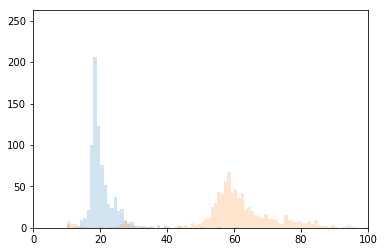

In [12]:
ax = plt.subplot(1,1,1)
H.plot(axes=ax,alpha=0.2)
circllhist_from_valuelist(reconstruct(H)).plot(axes=ax,alpha=0.2)
ax.set_xlim(0,100)

In [13]:
# OK that worked.

# Raw dataset

In [14]:
RL = [ reconstruct(H) for H in HL if H.count() > 0 ]

In [15]:
# Total R
RT = np.concatenate(RL)

In [16]:
%%script false # SKIP}
## VISUALS ##
from matplotlib import pyplot as plt
import seaborn as sns
fig = plt.figure(figsize=(30,60))
fig.subplots_adjust(hspace = .8)
for i,R in enumerate(RL):
    ax = plt.subplot(len(RL),1,i+1)
    ax.set_xlim(0,500)
    ax.set_title("Recorded latencies at {}:00 .. {}:00 UTC".format(i,i+1))
    sns.rugplot(R[::10], ax=ax, alpha=0.5,height=1)

# Exact computations

For this example we will use the following statistics:

- mean
- median
- p95, p99, p99.9
- max

and compare the relative errors, of the merged data to the precise data.

In [17]:
stats = "mean median p95 p99 p999 p9999 max".split()

In [18]:
stats_np = {
    "mean"   : lambda R: np.mean(R),
    "median" : lambda R: np.percentile(R, 50),
    "p95"    : lambda R: np.percentile(R, 95),
    "p99"    : lambda R: np.percentile(R, 99),
    "p999"    : lambda R: np.percentile(R, 99.9),
    "p9999"    : lambda R: np.percentile(R, 99.99),
    "max"    : lambda R: np.percentile(R, 100),
}

In [19]:
stats_total = { k : stats_np[k](RT) for k in stats }

In [20]:
print("True stats of the merged dataset")

def relative_error_pct(true_val, val):
    delta = val - true_val
    return delta / true_val * 100

def p_head(prefix):
    print(prefix + "".join([ "{:>20}".format(k) for k in stats]))
def p_rec(prefix, rec):
    print(prefix + "".join([ "{:>20.3f}".format(rec[k]) for k in stats]))
def p_report(name, stats_t):
    stats_err = { k: relative_error_pct(stats_total[k], stats_t[k]) for k in stats }
    p_rec(name + "      ", stats_t)
    p_rec(name + " ERR% ", stats_err)    
    
p_head("")
p_rec("", stats_total)

True stats of the merged dataset
                mean              median                 p95                 p99                p999               p9999                 max
             195.365              65.485             294.929            3493.242           18694.440           33446.793           37825.126


# Naive Aggregation: Mean values

In [21]:
# Row wise statistics:
SL = [ { k : stats_np[k](R) for k in stats }  for R in RL ]

In [22]:
p_head("batch")
for i,S in enumerate(SL[:10]):
    p_rec("{:>5} ".format(i), S)
print("...")

batch                mean              median                 p95                 p99                p999               p9999                 max
    0               66.300              59.949              85.621             166.020             844.008            2315.962            2479.512
    1               73.984              60.818             118.592             442.024             797.340             815.789             817.838
    2               71.030              60.356              93.636             412.100             899.813            1117.451            1141.634
    3              117.507              58.889             286.321            1630.200            4239.707            4462.027            4486.730
    4               77.548              56.079             106.574             717.413            2292.155            3108.568            3199.281
    5               77.971              56.073             104.302             715.943            2411.662            3

In [23]:
# Column Averages

In [24]:
stats_avg = { k : np.mean([ S[k] for S in SL ]) for k in stats }

p_head("             ")
p_rec("             ",stats_total)
p_report("Average", stats_avg)

                             mean              median                 p95                 p99                p999               p9999                 max
                          195.365              65.485             294.929            3493.242           18694.440           33446.793           37825.126
Average                   174.487             111.766             484.713            1261.812            2020.983            2299.914            2335.437
Average ERR%              -10.687              70.674              64.349             -63.878             -89.189             -93.124             -93.826


# HRD Histograms

In [25]:
HL = [ circllhist_from_valuelist(R) for R in RL  ]

In [26]:
HT = Circllhist()
for H in HL:
    HT.merge(H)

In [27]:
stats_circllhist_f = { 
    "size" : lambda H: len(H.to_b64())/4*3,
    "mean" : lambda H: H.mean(),
    "median" : lambda H : H.quantile(.5),
    "p95" : lambda H : H.quantile(.95),
    "p99" : lambda H : H.quantile(.99),
    "p999" : lambda H : H.quantile(.999),
    "p9999" : lambda H : H.quantile(.9999),
    "max" :   lambda H : H.quantile(1),
}

In [28]:
stats_circllhist = { k : stats_circllhist_f[k](HT) for k in stats }

In [29]:
p_head("                ")
p_rec("                ",stats_total)
p_report("CIRCLLHIST", stats_circllhist)

                                mean              median                 p95                 p99                p999               p9999                 max
                             195.365              65.485             294.929            3493.242           18694.440           33446.793           37825.126
CIRCLLHIST                   195.418              65.490             294.356            3492.782           18729.961           33471.012           38000.000
CIRCLLHIST ERR%                0.027               0.008              -0.194              -0.013               0.190               0.072               0.462


# T-Digest

Python version can't do merges, so we use a JAVA.

In [30]:
!rm data.csv
!rm results.out
!rm results.tsv
# Export
with open("data.csv","w") as fh:
    for i,R in enumerate(RL):
        for v in R:
            fh.write("{}\t{}\n".format(i, v))

In [31]:
!cat data.csv | java -jar tdigest-merge-tool.jar .5 .9 .95 .99 .999 .9999 1 | tee results.out

HistogramMergeTool
- Input Quantile: 0.500000
- Input Quantile: 0.900000
- Input Quantile: 0.950000
- Input Quantile: 0.990000
- Input Quantile: 0.999000
- Input Quantile: 0.999900
- Input Quantile: 1.000000
Merging  1006 batches
size	1540
q0.500000	65.493744
q0.900000	115.360240
q0.950000	296.730357
q0.990000	3512.591477
q0.999000	18694.315776
q0.999900	33448.835551
q1.000000	37825.126123


In [32]:
# Import raw results
!cat results.out > results.tsv
!cat results.tsv
print()
def import_results():
    with open("results.tsv") as fh:
        lines = fh.readlines()
    pairs = [ l.strip().split("\t") for l in lines ]
    return {
        k : float(v) for k,v in pairs
    }

res = import_results();

stats_td = {
    "size" : res["size"],
    "mean" : np.NAN, # not given
    "median" : res["q0.500000"],
    "p95"  : res["q0.950000"],
    "p99"  : res["q0.990000"],
    "p999" : res["q0.999000"],
    "p9999": res["q0.999900"],
    "max"  : res["q1.000000"],
}

p_report("TDigest", stats_td)

size	1540
q0.500000	65.493744
q0.900000	115.360240
q0.950000	296.730357
q0.990000	3512.591477
q0.999000	18694.315776
q0.999900	33448.835551
q1.000000	37825.126123

TDigest                       nan              65.494             296.730            3512.591           18694.316           33448.836           37825.126
TDigest ERR%                  nan               0.013               0.611               0.554              -0.001               0.006              -0.000


# Summary

In [33]:
print("\n\n### Merging {} batches @ {} seconds ###\n\n".format(COUNT, PERIOD))
p_head("                ")
p_rec("TOTAL:          ", stats_total)
print()
p_report("AVG       ", stats_avg)
print()
p_report("CIRCLLHIST", stats_circllhist)
print()
p_report("TDigest   ", stats_td)




### Merging 1440 batches @ 60 seconds ###


                                mean              median                 p95                 p99                p999               p9999                 max
TOTAL:                       195.365              65.485             294.929            3493.242           18694.440           33446.793           37825.126

AVG                          174.487             111.766             484.713            1261.812            2020.983            2299.914            2335.437
AVG        ERR%              -10.687              70.674              64.349             -63.878             -89.189             -93.124             -93.826

CIRCLLHIST                   195.418              65.490             294.356            3492.782           18729.961           33471.012           38000.000
CIRCLLHIST ERR%                0.027               0.008              -0.194              -0.013               0.190               0.072               0.462

TDigest  